In [233]:
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import nltk
import contractions
import string
import fasttext
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
plt.xticks(rotation=70)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
fasttext.FastText.eprint = lambda x: None
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Klaudiuszek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Klaudiuszek\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Loading dataset

In [234]:
df = pd.read_csv("1429_1.csv", low_memory=False, usecols=['id', 'name', 'asins', 'brand', 'reviews.numHelpful','reviews.rating', 'reviews.text', 'reviews.username', 'reviews.date'])

In [235]:
df.head()

,id,name,asins,brand,reviews.date,reviews.numHelpful,reviews.rating,reviews.text,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13T00:00:00.000Z,0.0,5.0,This product so far has not disappointed. My children love to use it and I like the ability to m...,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13T00:00:00.000Z,0.0,5.0,great for beginner or experienced person. Bought as a gift and she loves it,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13T00:00:00.000Z,0.0,5.0,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, ...",DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13T00:00:00.000Z,0.0,4.0,I've had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime Mem...,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-12T00:00:00.000Z,0.0,5.0,I bought this for my grand daughter when she comes over to visit. I set it up with her as the us...,explore42


# Droping NaN values

In [236]:
df.dropna(inplace=True)

# Renaming columns

In [237]:
df.rename(columns={"id": "reviewer_id", "name": "product_name", "asins": "product_id", "reviews.username": "reviewer_name"}, inplace=True)

# Making new "feedback" column, where 1 means positive feedback and 0 - negative, based on the review score

In [238]:
def feedback(x):
    if x['reviews.rating'] < 3:
        return 0
    else:
        return 1
    
df['feedback'] = df.apply(lambda x: feedback(x), axis=1)

In [239]:
df.head()

,reviewer_id,product_name,product_id,brand,reviews.date,reviews.numHelpful,reviews.rating,reviews.text,reviewer_name,feedback
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13T00:00:00.000Z,0.0,5.0,This product so far has not disappointed. My children love to use it and I like the ability to m...,Adapter,1
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13T00:00:00.000Z,0.0,5.0,great for beginner or experienced person. Bought as a gift and she loves it,truman,1
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13T00:00:00.000Z,0.0,5.0,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, ...",DaveZ,1
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13T00:00:00.000Z,0.0,4.0,I've had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime Mem...,Shacks,1
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-12T00:00:00.000Z,0.0,5.0,I bought this for my grand daughter when she comes over to visit. I set it up with her as the us...,explore42,1


# Changing reviews.date to simpler version

In [240]:
df['reviews.date'] = df['reviews.date'].apply(lambda i: i[:10])

In [241]:
df.head()

,reviewer_id,product_name,product_id,brand,reviews.date,reviews.numHelpful,reviews.rating,reviews.text,reviewer_name,feedback
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,This product so far has not disappointed. My children love to use it and I like the ability to m...,Adapter,1
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,great for beginner or experienced person. Bought as a gift and she loves it,truman,1
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, ...",DaveZ,1
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,4.0,I've had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime Mem...,Shacks,1
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-12,0.0,5.0,I bought this for my grand daughter when she comes over to visit. I set it up with her as the us...,explore42,1


# Normalizing strings to ascii, utf8, nfkd

In [242]:
df['reviewer_name'] = df['reviewer_name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df['reviews.text'] = df['reviews.text'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# Expanding contractions

In [243]:
df['no_contract'] = df['reviews.text'].apply(lambda x: [contractions.fix(word) for word in x.split()])
df.head()

,reviewer_id,product_name,product_id,brand,reviews.date,reviews.numHelpful,reviews.rating,reviews.text,reviewer_name,feedback,no_contract
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,This product so far has not disappointed. My children love to use it and I like the ability to m...,Adapter,1,"[This, product, so, far, has, not, disappointed., My, children, love, to, use, it, and, I, like,..."
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,great for beginner or experienced person. Bought as a gift and she loves it,truman,1,"[great, for, beginner, or, experienced, person., Bought, as, a, gift, and, she, loves, it]"
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, ...",DaveZ,1,"[Inexpensive, tablet, for, him, to, use, and, learn, on,, step, up, from, the, NABI., He, was, t..."
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,4.0,I've had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime Mem...,Shacks,1,"[I have, had, my, Fire, HD, 8, two, weeks, now, and, I, love, it., This, tablet, is, a, great, v..."
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-12,0.0,5.0,I bought this for my grand daughter when she comes over to visit. I set it up with her as the us...,explore42,1,"[I, bought, this, for, my, grand, daughter, when, she, comes, over, to, visit., I, set, it, up, ..."


In [244]:
df['rating_description_str'] = [' '.join(map(str, l)) for l in df['no_contract']]
df.head()

,reviewer_id,product_name,product_id,brand,reviews.date,reviews.numHelpful,reviews.rating,reviews.text,reviewer_name,feedback,no_contract,rating_description_str
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,This product so far has not disappointed. My children love to use it and I like the ability to m...,Adapter,1,"[This, product, so, far, has, not, disappointed., My, children, love, to, use, it, and, I, like,...",This product so far has not disappointed. My children love to use it and I like the ability to m...
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,great for beginner or experienced person. Bought as a gift and she loves it,truman,1,"[great, for, beginner, or, experienced, person., Bought, as, a, gift, and, she, loves, it]",great for beginner or experienced person. Bought as a gift and she loves it
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, ...",DaveZ,1,"[Inexpensive, tablet, for, him, to, use, and, learn, on,, step, up, from, the, NABI., He, was, t...","Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, ..."
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,4.0,I've had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime Mem...,Shacks,1,"[I have, had, my, Fire, HD, 8, two, weeks, now, and, I, love, it., This, tablet, is, a, great, v...",I have had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime M...
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-12,0.0,5.0,I bought this for my grand daughter when she comes over to visit. I set it up with her as the us...,explore42,1,"[I, bought, this, for, my, grand, daughter, when, she, comes, over, to, visit., I, set, it, up, ...",I bought this for my grand daughter when she comes over to visit. I set it up with her as the us...


In [245]:
df.drop('reviews.text', axis=1, inplace=True)
df.drop('no_contract', axis=1, inplace=True)

In [246]:
df.rename(columns={'rating_description_str': 'description'}, inplace=True)

In [247]:
df.head()

,reviewer_id,product_name,product_id,brand,reviews.date,reviews.numHelpful,reviews.rating,reviewer_name,feedback,description
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,Adapter,1,This product so far has not disappointed. My children love to use it and I like the ability to m...
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,truman,1,great for beginner or experienced person. Bought as a gift and she loves it
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,DaveZ,1,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, ..."
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,4.0,Shacks,1,I have had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime M...
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-12,0.0,5.0,explore42,1,I bought this for my grand daughter when she comes over to visit. I set it up with her as the us...


# Detecting english language

In [248]:
model = fasttext.load_model('F:\\Users\\Klaudiuszek\\anaconda3\\Lib\\site-packages\\fasttext\\lid.176.bin')
langs = []
for sent in df['description']:
    lang = model.predict(sent)[0]
    langs.append(str(lang)[11:13])
df['langs'] = langs

In [249]:
df.drop(df[df['langs'] != 'en'].index, inplace=True)

# Tokenization

In [250]:
df['tokenized'] = df['description'].apply(word_tokenize)
df.head()

,reviewer_id,product_name,product_id,brand,reviews.date,reviews.numHelpful,reviews.rating,reviewer_name,feedback,description,langs,tokenized
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,Adapter,1,This product so far has not disappointed. My children love to use it and I like the ability to m...,en,"[This, product, so, far, has, not, disappointed, ., My, children, love, to, use, it, and, I, lik..."
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,truman,1,great for beginner or experienced person. Bought as a gift and she loves it,en,"[great, for, beginner, or, experienced, person, ., Bought, as, a, gift, and, she, loves, it]"
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,DaveZ,1,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, ...",en,"[Inexpensive, tablet, for, him, to, use, and, learn, on, ,, step, up, from, the, NABI, ., He, wa..."
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,4.0,Shacks,1,I have had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime M...,en,"[I, have, had, my, Fire, HD, 8, two, weeks, now, and, I, love, it, ., This, tablet, is, a, great..."
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-12,0.0,5.0,explore42,1,I bought this for my grand daughter when she comes over to visit. I set it up with her as the us...,en,"[I, bought, this, for, my, grand, daughter, when, she, comes, over, to, visit, ., I, set, it, up..."


# Converting to lower-case

In [251]:
df['lower'] = df['tokenized'].apply(lambda x: [word.lower() for word in x])
df.head()

,reviewer_id,product_name,product_id,brand,reviews.date,reviews.numHelpful,reviews.rating,reviewer_name,feedback,description,langs,tokenized,lower
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,Adapter,1,This product so far has not disappointed. My children love to use it and I like the ability to m...,en,"[This, product, so, far, has, not, disappointed, ., My, children, love, to, use, it, and, I, lik...","[this, product, so, far, has, not, disappointed, ., my, children, love, to, use, it, and, i, lik..."
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,truman,1,great for beginner or experienced person. Bought as a gift and she loves it,en,"[great, for, beginner, or, experienced, person, ., Bought, as, a, gift, and, she, loves, it]","[great, for, beginner, or, experienced, person, ., bought, as, a, gift, and, she, loves, it]"
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,DaveZ,1,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, ...",en,"[Inexpensive, tablet, for, him, to, use, and, learn, on, ,, step, up, from, the, NABI, ., He, wa...","[inexpensive, tablet, for, him, to, use, and, learn, on, ,, step, up, from, the, nabi, ., he, wa..."
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,4.0,Shacks,1,I have had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime M...,en,"[I, have, had, my, Fire, HD, 8, two, weeks, now, and, I, love, it, ., This, tablet, is, a, great...","[i, have, had, my, fire, hd, 8, two, weeks, now, and, i, love, it, ., this, tablet, is, a, great..."
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-12,0.0,5.0,explore42,1,I bought this for my grand daughter when she comes over to visit. I set it up with her as the us...,en,"[I, bought, this, for, my, grand, daughter, when, she, comes, over, to, visit, ., I, set, it, up...","[i, bought, this, for, my, grand, daughter, when, she, comes, over, to, visit, ., i, set, it, up..."


# Removing punctuations

In [252]:
punc = string.punctuation
df['no_punc'] = df['lower'].apply(lambda x: [word for word in x if word not in punc])
df.head()

,reviewer_id,product_name,product_id,brand,reviews.date,reviews.numHelpful,reviews.rating,reviewer_name,feedback,description,langs,tokenized,lower,no_punc
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,Adapter,1,This product so far has not disappointed. My children love to use it and I like the ability to m...,en,"[This, product, so, far, has, not, disappointed, ., My, children, love, to, use, it, and, I, lik...","[this, product, so, far, has, not, disappointed, ., my, children, love, to, use, it, and, i, lik...","[this, product, so, far, has, not, disappointed, my, children, love, to, use, it, and, i, like, ..."
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,truman,1,great for beginner or experienced person. Bought as a gift and she loves it,en,"[great, for, beginner, or, experienced, person, ., Bought, as, a, gift, and, she, loves, it]","[great, for, beginner, or, experienced, person, ., bought, as, a, gift, and, she, loves, it]","[great, for, beginner, or, experienced, person, bought, as, a, gift, and, she, loves, it]"
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,DaveZ,1,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, ...",en,"[Inexpensive, tablet, for, him, to, use, and, learn, on, ,, step, up, from, the, NABI, ., He, wa...","[inexpensive, tablet, for, him, to, use, and, learn, on, ,, step, up, from, the, nabi, ., he, wa...","[inexpensive, tablet, for, him, to, use, and, learn, on, step, up, from, the, nabi, he, was, thr..."
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,4.0,Shacks,1,I have had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime M...,en,"[I, have, had, my, Fire, HD, 8, two, weeks, now, and, I, love, it, ., This, tablet, is, a, great...","[i, have, had, my, fire, hd, 8, two, weeks, now, and, i, love, it, ., this, tablet, is, a, great...","[i, have, had, my, fire, hd, 8, two, weeks, now, and, i, love, it, this, tablet, is, a, great, v..."
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-12,0.0,5.0,explore42,1,I bought this for my grand daughter when she comes over to visit. I set it up with her as the us...,en,"[I, bought, this, for, my, grand, daughter, when, she, comes, over, to, visit, ., I, set, it, up...","[i, bought, this, for, my, grand, daughter, when, she, comes, over, to, visit, ., i, set, it, up...","[i, bought, this, for, my, grand, daughter, when, she, comes, over, to, visit, i, set, it, up, w..."


# Removing stopwards

In [253]:
stop_words = set(stopwords.words('english'))
df['stopwords_removed'] = df['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
df.head()

,reviewer_id,product_name,product_id,brand,reviews.date,reviews.numHelpful,reviews.rating,reviewer_name,feedback,description,langs,tokenized,lower,no_punc,stopwords_removed
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,Adapter,1,This product so far has not disappointed. My children love to use it and I like the ability to m...,en,"[This, product, so, far, has, not, disappointed, ., My, children, love, to, use, it, and, I, lik...","[this, product, so, far, has, not, disappointed, ., my, children, love, to, use, it, and, i, lik...","[this, product, so, far, has, not, disappointed, my, children, love, to, use, it, and, i, like, ...","[product, far, disappointed, children, love, use, like, ability, monitor, control, content, see,..."
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,truman,1,great for beginner or experienced person. Bought as a gift and she loves it,en,"[great, for, beginner, or, experienced, person, ., Bought, as, a, gift, and, she, loves, it]","[great, for, beginner, or, experienced, person, ., bought, as, a, gift, and, she, loves, it]","[great, for, beginner, or, experienced, person, bought, as, a, gift, and, she, loves, it]","[great, beginner, experienced, person, bought, gift, loves]"
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,DaveZ,1,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, ...",en,"[Inexpensive, tablet, for, him, to, use, and, learn, on, ,, step, up, from, the, NABI, ., He, wa...","[inexpensive, tablet, for, him, to, use, and, learn, on, ,, step, up, from, the, nabi, ., he, wa...","[inexpensive, tablet, for, him, to, use, and, learn, on, step, up, from, the, nabi, he, was, thr...","[inexpensive, tablet, use, learn, step, nabi, thrilled, learn, skype, already, ...]"
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,4.0,Shacks,1,I have had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime M...,en,"[I, have, had, my, Fire, HD, 8, two, weeks, now, and, I, love, it, ., This, tablet, is, a, great...","[i, have, had, my, fire, hd, 8, two, weeks, now, and, i, love, it, ., this, tablet, is, a, great...","[i, have, had, my, fire, hd, 8, two, weeks, now, and, i, love, it, this, tablet, is, a, great, v...","[fire, hd, 8, two, weeks, love, tablet, great, value.we, prime, members, tablet, shines, love, a..."
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-12,0.0,5.0,explore42,1,I bought this for my grand daughter when she comes over to visit. I set it up with her as the us...,en,"[I, bought, this, for, my, grand, daughter, when, she, comes, over, to, visit, ., I, set, it, up...","[i, bought, this, for, my, grand, daughter, when, she, comes, over, to, visit, ., i, set, it, up...","[i, bought, this, for, my, grand, daughter, when, she, comes, over, to, visit, i, set, it, up, w...","[bought, grand, daughter, comes, visit, set, user, entered, age, name, amazon, makes, sure, acce..."


# Lemmanization

In [254]:
df['pos_tags'] = df['stopwords_removed'].apply(nltk.tag.pos_tag)
df.head()

,reviewer_id,product_name,product_id,brand,reviews.date,reviews.numHelpful,reviews.rating,reviewer_name,feedback,description,langs,tokenized,lower,no_punc,stopwords_removed,pos_tags
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,Adapter,1,This product so far has not disappointed. My children love to use it and I like the ability to m...,en,"[This, product, so, far, has, not, disappointed, ., My, children, love, to, use, it, and, I, lik...","[this, product, so, far, has, not, disappointed, ., my, children, love, to, use, it, and, i, lik...","[this, product, so, far, has, not, disappointed, my, children, love, to, use, it, and, i, like, ...","[product, far, disappointed, children, love, use, like, ability, monitor, control, content, see,...","[(product, NN), (far, RB), (disappointed, JJ), (children, NNS), (love, VBP), (use, NN), (like, I..."
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,truman,1,great for beginner or experienced person. Bought as a gift and she loves it,en,"[great, for, beginner, or, experienced, person, ., Bought, as, a, gift, and, she, loves, it]","[great, for, beginner, or, experienced, person, ., bought, as, a, gift, and, she, loves, it]","[great, for, beginner, or, experienced, person, bought, as, a, gift, and, she, loves, it]","[great, beginner, experienced, person, bought, gift, loves]","[(great, JJ), (beginner, NN), (experienced, VBD), (person, NN), (bought, VBD), (gift, NN), (love..."
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,DaveZ,1,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, ...",en,"[Inexpensive, tablet, for, him, to, use, and, learn, on, ,, step, up, from, the, NABI, ., He, wa...","[inexpensive, tablet, for, him, to, use, and, learn, on, ,, step, up, from, the, nabi, ., he, wa...","[inexpensive, tablet, for, him, to, use, and, learn, on, step, up, from, the, nabi, he, was, thr...","[inexpensive, tablet, use, learn, step, nabi, thrilled, learn, skype, already, ...]","[(inexpensive, JJ), (tablet, NN), (use, NN), (learn, JJ), (step, NN), (nabi, RB), (thrilled, VBD..."
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,4.0,Shacks,1,I have had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime M...,en,"[I, have, had, my, Fire, HD, 8, two, weeks, now, and, I, love, it, ., This, tablet, is, a, great...","[i, have, had, my, fire, hd, 8, two, weeks, now, and, i, love, it, ., this, tablet, is, a, great...","[i, have, had, my, fire, hd, 8, two, weeks, now, and, i, love, it, this, tablet, is, a, great, v...","[fire, hd, 8, two, weeks, love, tablet, great, value.we, prime, members, tablet, shines, love, a...","[(fire, NN), (hd, VBZ), (8, CD), (two, CD), (weeks, NNS), (love, VBP), (tablet, RB), (great, JJ)..."
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-12,0.0,5.0,explore42,1,I bought this for my grand daughter when she comes over to visit. I set it up with her as the us...,en,"[I, bought, this, for, my, grand, daughter, when, she, comes, over, to, visit, ., I, set, it, up...","[i, bought, this, for, my, grand, daughter, when, she, comes, over, to, visit, ., i, set, it, up...","[i, bought, this, for, my, grand, daughter, when, she, comes, over, to, visit, i, set, it, up, w...","[bought, grand, daughter, comes, visit, set, user, entered, age, name, amazon, makes, sure, acce...","[(bought, VBN), (grand, JJ), (daughter, NN), (comes, VBZ), (visit, RB), (set, VBN), (user, NN), ..."


In [255]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
df['wordnet_pos'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df.head()

,reviewer_id,product_name,product_id,brand,reviews.date,reviews.numHelpful,reviews.rating,reviewer_name,feedback,description,langs,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,Adapter,1,This product so far has not disappointed. My children love to use it and I like the ability to m...,en,"[This, product, so, far, has, not, disappointed, ., My, children, love, to, use, it, and, I, lik...","[this, product, so, far, has, not, disappointed, ., my, children, love, to, use, it, and, i, lik...","[this, product, so, far, has, not, disappointed, my, children, love, to, use, it, and, i, like, ...","[product, far, disappointed, children, love, use, like, ability, monitor, control, content, see,...","[(product, NN), (far, RB), (disappointed, JJ), (children, NNS), (love, VBP), (use, NN), (like, I...","[(product, n), (far, r), (disappointed, a), (children, n), (love, v), (use, n), (like, n), (abil..."
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,truman,1,great for beginner or experienced person. Bought as a gift and she loves it,en,"[great, for, beginner, or, experienced, person, ., Bought, as, a, gift, and, she, loves, it]","[great, for, beginner, or, experienced, person, ., bought, as, a, gift, and, she, loves, it]","[great, for, beginner, or, experienced, person, bought, as, a, gift, and, she, loves, it]","[great, beginner, experienced, person, bought, gift, loves]","[(great, JJ), (beginner, NN), (experienced, VBD), (person, NN), (bought, VBD), (gift, NN), (love...","[(great, a), (beginner, n), (experienced, v), (person, n), (bought, v), (gift, n), (loves, n)]"
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,DaveZ,1,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, ...",en,"[Inexpensive, tablet, for, him, to, use, and, learn, on, ,, step, up, from, the, NABI, ., He, wa...","[inexpensive, tablet, for, him, to, use, and, learn, on, ,, step, up, from, the, nabi, ., he, wa...","[inexpensive, tablet, for, him, to, use, and, learn, on, step, up, from, the, nabi, he, was, thr...","[inexpensive, tablet, use, learn, step, nabi, thrilled, learn, skype, already, ...]","[(inexpensive, JJ), (tablet, NN), (use, NN), (learn, JJ), (step, NN), (nabi, RB), (thrilled, VBD...","[(inexpensive, a), (tablet, n), (use, n), (learn, a), (step, n), (nabi, r), (thrilled, v), (lear..."
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,4.0,Shacks,1,I have had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime M...,en,"[I, have, had, my, Fire, HD, 8, two, weeks, now, and, I, love, it, ., This, tablet, is, a, great...","[i, have, had, my, fire, hd, 8, two, weeks, now, and, i, love, it, ., this, tablet, is, a, great...","[i, have, had, my, fire, hd, 8, two, weeks, now, and, i, love, it, this, tablet, is, a, great, v...","[fire, hd, 8, two, weeks, love, tablet, great, value.we, prime, members, tablet, shines, love, a...","[(fire, NN), (hd, VBZ), (8, CD), (two, CD), (weeks, NNS), (love, VBP), (tablet, RB), (great, JJ)...","[(fire, n), (hd, v), (8, n), (two, n), (weeks, n), (love, v), (tablet, r), (great, a), (value.we..."
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-12,0.0,5.0,explore42,1,I bought this for my grand daughter when she comes over to visit. I set it up with her as the us...,en,"[I, bought, this, for, my, grand, daughter, when, she, comes, over, to, visit, ., I, set, it, up...","[i, bought, this, for, my, grand, daughter, when,

In [256]:
wnl = WordNetLemmatizer()
df['lemmatized'] = df['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df.head()

,reviewer_id,product_name,product_id,brand,reviews.date,reviews.numHelpful,reviews.rating,reviewer_name,feedback,description,langs,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos,lemmatized
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,Adapter,1,This product so far has not disappointed. My children love to use it and I like the ability to m...,en,"[This, product, so, far, has, not, disappointed, ., My, children, love, to, use, it, and, I, lik...","[this, product, so, far, has, not, disappointed, ., my, children, love, to, use, it, and, i, lik...","[this, product, so, far, has, not, disappointed, my, children, love, to, use, it, and, i, like, ...","[product, far, disappointed, children, love, use, like, ability, monitor, control, content, see,...","[(product, NN), (far, RB), (disappointed, JJ), (children, NNS), (love, VBP), (use, NN), (like, I...","[(product, n), (far, r), (disappointed, a), (children, n), (love, v), (use, n), (like, n), (abil...","[product, far, disappointed, child, love, use, like, ability, monitor, control, content, see, ease]"
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,truman,1,great for beginner or experienced person. Bought as a gift and she loves it,en,"[great, for, beginner, or, experienced, person, ., Bought, as, a, gift, and, she, loves, it]","[great, for, beginner, or, experienced, person, ., bought, as, a, gift, and, she, loves, it]","[great, for, beginner, or, experienced, person, bought, as, a, gift, and, she, loves, it]","[great, beginner, experienced, person, bought, gift, loves]","[(great, JJ), (beginner, NN), (experienced, VBD), (person, NN), (bought, VBD), (gift, NN), (love...","[(great, a), (beginner, n), (experienced, v), (person, n), (bought, v), (gift, n), (loves, n)]","[great, beginner, experience, person, buy, gift, love]"
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,DaveZ,1,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, ...",en,"[Inexpensive, tablet, for, him, to, use, and, learn, on, ,, step, up, from, the, NABI, ., He, wa...","[inexpensive, tablet, for, him, to, use, and, learn, on, ,, step, up, from, the, nabi, ., he, wa...","[inexpensive, tablet, for, him, to, use, and, learn, on, step, up, from, the, nabi, he, was, thr...","[inexpensive, tablet, use, learn, step, nabi, thrilled, learn, skype, already, ...]","[(inexpensive, JJ), (tablet, NN), (use, NN), (learn, JJ), (step, NN), (nabi, RB), (thrilled, VBD...","[(inexpensive, a), (tablet, n), (use, n), (learn, a), (step, n), (nabi, r), (thrilled, v), (lear...","[inexpensive, tablet, use, learn, step, nabi, thrill, learn, skype, already, ...]"
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,4.0,Shacks,1,I have had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime M...,en,"[I, have, had, my, Fire, HD, 8, two, weeks, now, and, I, love, it, ., This, tablet, is, a, great...","[i, have, had, my, fire, hd, 8, two, weeks, now, and, i, love, it, ., this, tablet, is, a, great...","[i, have, had, my, fire, hd, 8, two, weeks, now, and, i, love, it, this, tablet, is, a, great, v...","[fire, hd, 8, two, weeks, love, tablet, great, value.we, prime, members, tablet, shines, love, a...","[(fire, NN), (hd, VBZ), (8, CD), (two, CD), (weeks, NNS), (love, VBP), (tablet, RB), (great, JJ)...","[(fire, n), (hd, v), (8, n), (two, n), (weeks, n), (love, v), (tablet, r), (great, a), (value.we...","[fire, hd, 8, two, week, love, tablet, great, value.we, prime, member, tablet, shine, love, able..."
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Displa

In [257]:
df.head()

,reviewer_id,product_name,product_id,brand,reviews.date,reviews.numHelpful,reviews.rating,reviewer_name,feedback,description,langs,tokenized,lower,no_punc,stopwords_removed,pos_tags,wordnet_pos,lemmatized
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,Adapter,1,This product so far has not disappointed. My children love to use it and I like the ability to m...,en,"[This, product, so, far, has, not, disappointed, ., My, children, love, to, use, it, and, I, lik...","[this, product, so, far, has, not, disappointed, ., my, children, love, to, use, it, and, i, lik...","[this, product, so, far, has, not, disappointed, my, children, love, to, use, it, and, i, like, ...","[product, far, disappointed, children, love, use, like, ability, monitor, control, content, see,...","[(product, NN), (far, RB), (disappointed, JJ), (children, NNS), (love, VBP), (use, NN), (like, I...","[(product, n), (far, r), (disappointed, a), (children, n), (love, v), (use, n), (like, n), (abil...","[product, far, disappointed, child, love, use, like, ability, monitor, control, content, see, ease]"
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,truman,1,great for beginner or experienced person. Bought as a gift and she loves it,en,"[great, for, beginner, or, experienced, person, ., Bought, as, a, gift, and, she, loves, it]","[great, for, beginner, or, experienced, person, ., bought, as, a, gift, and, she, loves, it]","[great, for, beginner, or, experienced, person, bought, as, a, gift, and, she, loves, it]","[great, beginner, experienced, person, bought, gift, loves]","[(great, JJ), (beginner, NN), (experienced, VBD), (person, NN), (bought, VBD), (gift, NN), (love...","[(great, a), (beginner, n), (experienced, v), (person, n), (bought, v), (gift, n), (loves, n)]","[great, beginner, experience, person, buy, gift, love]"
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,5.0,DaveZ,1,"Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, ...",en,"[Inexpensive, tablet, for, him, to, use, and, learn, on, ,, step, up, from, the, NABI, ., He, wa...","[inexpensive, tablet, for, him, to, use, and, learn, on, ,, step, up, from, the, nabi, ., he, wa...","[inexpensive, tablet, for, him, to, use, and, learn, on, step, up, from, the, nabi, he, was, thr...","[inexpensive, tablet, use, learn, step, nabi, thrilled, learn, skype, already, ...]","[(inexpensive, JJ), (tablet, NN), (use, NN), (learn, JJ), (step, NN), (nabi, RB), (thrilled, VBD...","[(inexpensive, a), (tablet, n), (use, n), (learn, a), (step, n), (nabi, r), (thrilled, v), (lear...","[inexpensive, tablet, use, learn, step, nabi, thrill, learn, skype, already, ...]"
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",B01AHB9CN2,Amazon,2017-01-13,0.0,4.0,Shacks,1,I have had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime M...,en,"[I, have, had, my, Fire, HD, 8, two, weeks, now, and, I, love, it, ., This, tablet, is, a, great...","[i, have, had, my, fire, hd, 8, two, weeks, now, and, i, love, it, ., this, tablet, is, a, great...","[i, have, had, my, fire, hd, 8, two, weeks, now, and, i, love, it, this, tablet, is, a, great, v...","[fire, hd, 8, two, weeks, love, tablet, great, value.we, prime, members, tablet, shines, love, a...","[(fire, NN), (hd, VBZ), (8, CD), (two, CD), (weeks, NNS), (love, VBP), (tablet, RB), (great, JJ)...","[(fire, n), (hd, v), (8, n), (two, n), (weeks, n), (love, v), (tablet, r), (great, a), (value.we...","[fire, hd, 8, two, week, love, tablet, great, value.we, prime, member, tablet, shine, love, able..."
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Displa

# ---------Exploratory Data Analysis (EDA)---------

In [258]:
df['ready'] = df['lemmatized'].apply(lambda x: " ".join(x))

# The most common positive and negative words

In [259]:
df_pos = df[df['feedback'] == 1]

In [260]:
df_neg = df[df['feedback'] == 0]

In [261]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

## Positive words

In [262]:
common_words_pos = get_top_n_words(df_pos['ready'], 20)

In [263]:
l_pos = []
for i in range(len(common_words_pos)):
    for n in common_words_pos[i]:
        l_pos.append(n)

In [264]:
words_pos = l_pos[0::2]
values_pos = l_pos[1::2]

Text(0.5, 1.0, '20 most common positive words')

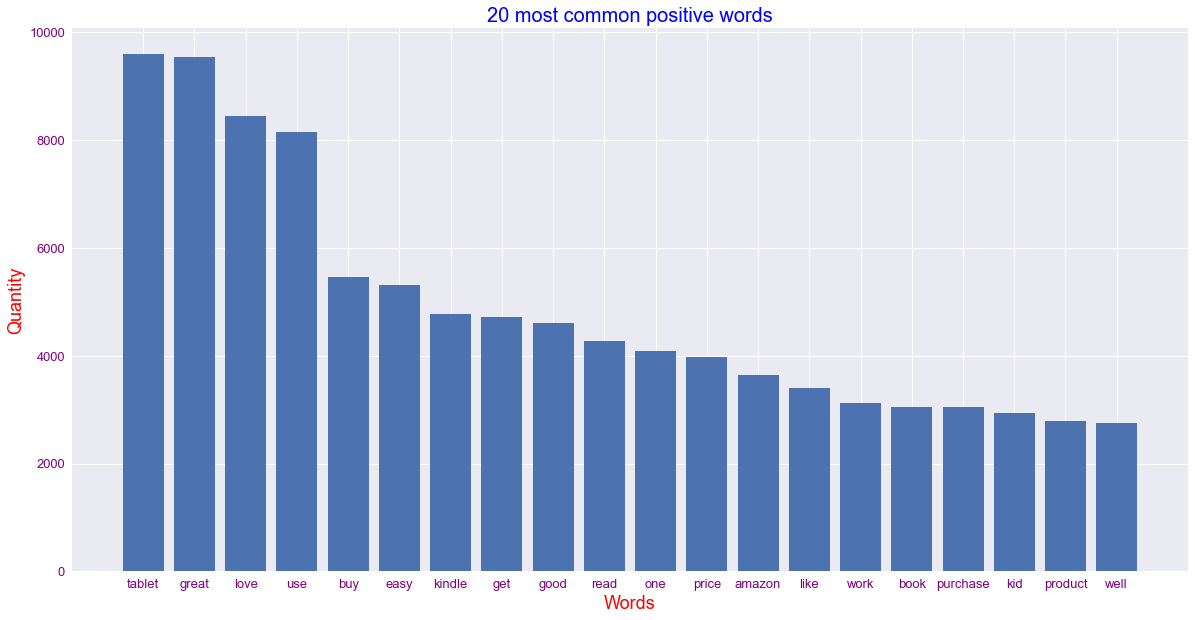

In [265]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))

plt.style.use('seaborn')

plt.bar(words_pos, values_pos)
plt.xlabel("Words", fontsize=18, color='red')
plt.ylabel("Quantity", fontsize=18, color='red')
plt.tick_params(axis='both', labelcolor='purple', labelsize=13)
plt.title("20 most common positive words", fontsize=20, color='blue')





## Negative words

In [266]:
common_words_neg = get_top_n_words(df_neg['ready'], 20)

In [267]:
l_neg = []
for i in range(len(common_words_neg)):
    for n in common_words_neg[i]:
        l_neg.append(n)

In [268]:
words_neg = l_neg[0::2]
values_neg = l_neg[1::2]

Text(0.5, 1.0, '20 most common negative words')

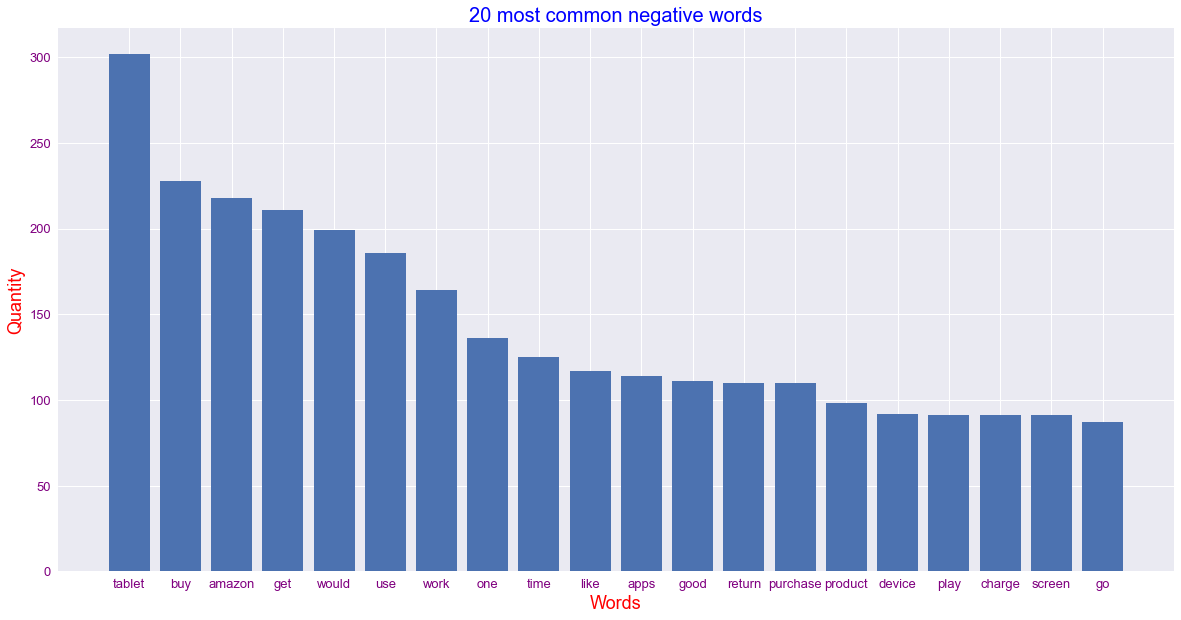

In [269]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))

plt.style.use('seaborn')

plt.bar(words_neg, values_neg)
plt.xlabel("Words", fontsize=18, color='red')
plt.ylabel("Quantity", fontsize=18, color='red')
plt.tick_params(axis='both', labelcolor='purple', labelsize=13)
plt.title("20 most common negative words", fontsize=20, color='blue')


# Number of reviews for top 20 products

In [270]:
product_quantity = []
for i in range(20):
    product_quantity.append(df["product_name"].value_counts().nlargest(n=20)[i])

In [271]:
product_names = []
for i in range(20):
    product_names.append(df['product_name'].value_counts()[:20].index.tolist()[i])

In [272]:
product_names[12] = product_names[12][:72]
product_names[11] = product_names[11][:72]
product_names[9] = product_names[9][:64]
product_names[1] = product_names[1][:12]
product_names[4] = product_names[4][:14]
product_names[14] = product_names[14][:99]
product_names[16] = product_names[16][:49]
product_names[17] = product_names[17][:89]

Text(0.5, 1.0, '20 most reviewed products')

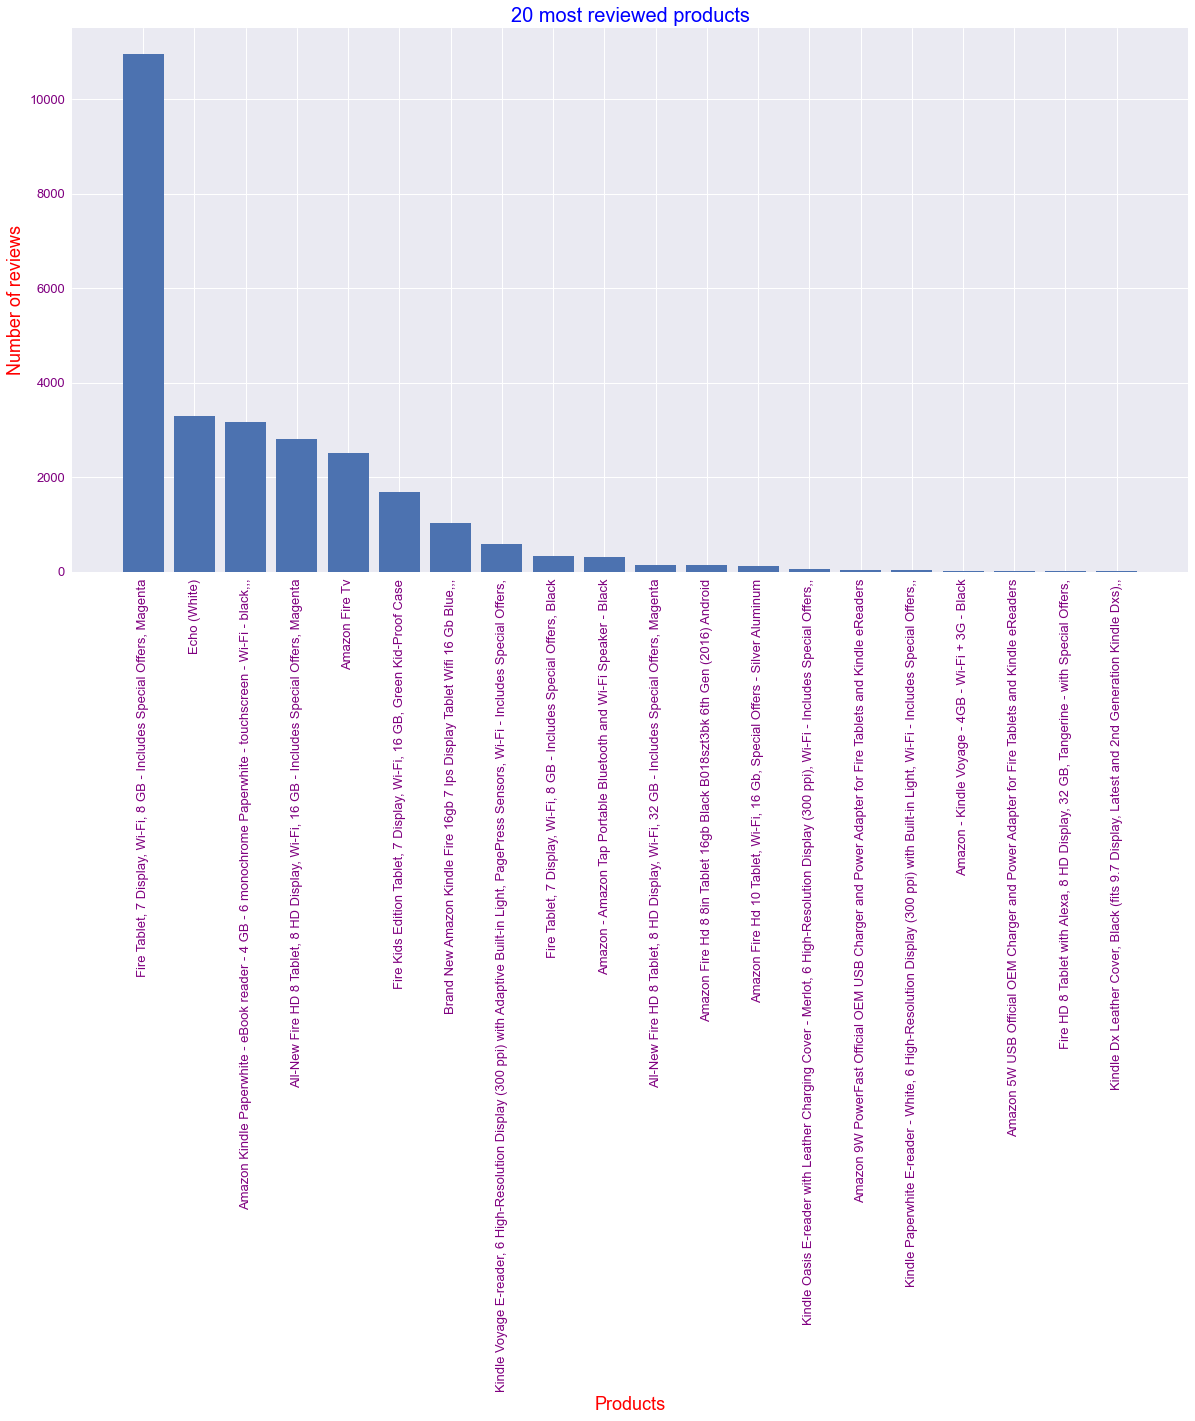

In [273]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))

plt.style.use('seaborn')

plt.bar(product_names, product_quantity)
plt.xlabel("Products", fontsize=18, color='red')
plt.ylabel("Number of reviews", fontsize=18, color='red')
plt.tick_params(axis='both', labelcolor='purple', labelsize=13)
plt.xticks(rotation=90)
plt.title("20 most reviewed products", fontsize=20, color='blue')

# Mean rating over years for most reviewed product

In [274]:
df_most_popular = df[df['product_name'] == 'Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta']

In [275]:
df_most_popular['year'] = df['reviews.date'].apply(lambda i: i[:4])

In [276]:
df_most_popular_2015 = df_most_popular[df_most_popular['year'] == '2015']
df_most_popular_2016 = df_most_popular[df_most_popular['year'] == '2016']
df_most_popular_2017 = df_most_popular[df_most_popular['year'] == '2017']

In [277]:
most_popular_2015_value = df_most_popular_2015['reviews.rating'].mean()
most_popular_2016_value = df_most_popular_2016['reviews.rating'].mean()
most_popular_2017_value = df_most_popular_2017['reviews.rating'].mean()

In [278]:
most_popular_2017_value

4.444308445532435

Text(0.5, 1.0, "Year vs mean rating for 'Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta' ")

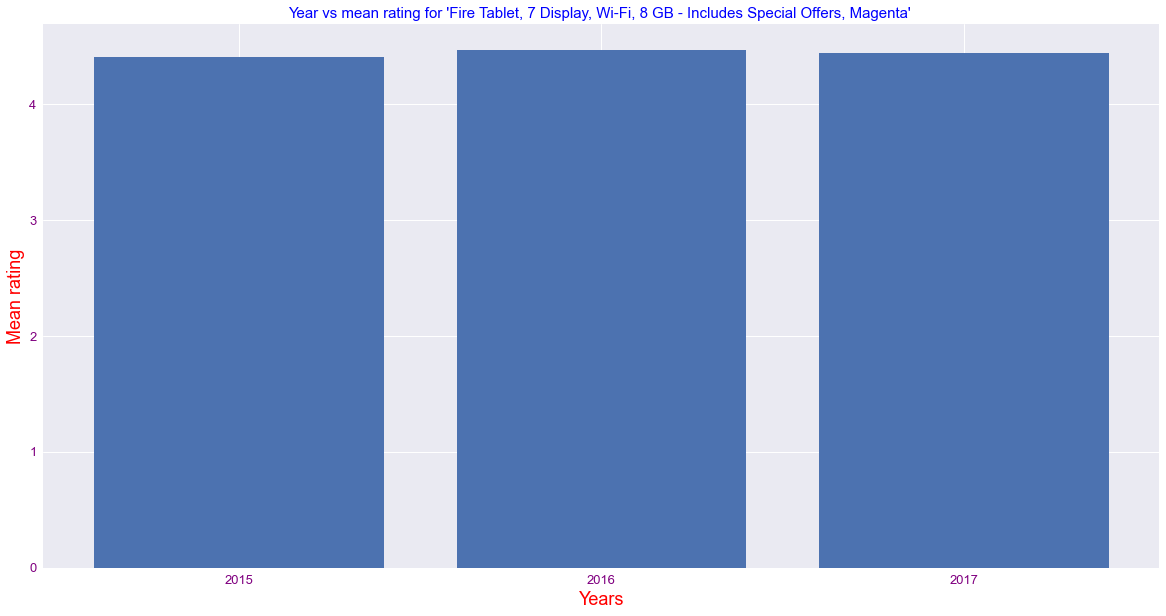

In [279]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))

plt.style.use('seaborn')

plt.bar(['2015', '2016', '2017'], [most_popular_2015_value, most_popular_2016_value, most_popular_2017_value])
plt.xlabel("Years", fontsize=18, color='red')
plt.ylabel("Mean rating", fontsize=18, color='red')
plt.tick_params(axis='both', labelcolor='purple', labelsize=13)
plt.title("Year vs mean rating for 'Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta' ", fontsize=15, color='blue')


# ---------Training model---------

In [221]:
X = df['lemmatized'].apply(lambda x: " ".join(x))
y = df['feedback']

In [228]:
ctmTr

<20557x8972 sparse matrix of type '<class 'numpy.int64'>'
	with 280728 stored elements in Compressed Sparse Row format>

# Logistic regression

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

# Vectorizing the text data
cv = CountVectorizer().fit(X_train)
ctmTr = cv.transform(X_train)
X_test_dtm = cv.transform(X_test)

#Training the model
lr = LogisticRegression(max_iter=1000)
lr.fit(ctmTr, y_train)

#Accuracy score
lr_score = lr.score(X_test_dtm, y_test)
print(f"Logistic regression score: {lr_score}")

#Predicting the labels for test data
y_pred_lr = lr.predict(X_test_dtm)

#Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()
print(tn, fp, fn, tp)

# True positive and true negative rates
tpr_lr = round(tp/(tp + fn), 4)
tnr_lr = round(tn/(tn+fp), 4)
print(tpr_lr, tnr_lr)

Logistic regression score: 0.9362323070188239
151 341 96 6265
0.9849 0.3069


# Support Vector Machine

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)
                                        
#Vectorizing the text data
cv = CountVectorizer()
ctmTr = cv.fit_transform(X_train)
X_test_dtm = cv.transform(X_test)

#Training the model
svcl = svm.SVC()
svcl.fit(ctmTr, y_train)

#Accuracy score
svcl_score = svcl.score(X_test_dtm, y_test)
print(f"SVM score: {svcl_score}")

#Predicting the labels for test data
y_pred_sv = svcl.predict(X_test_dtm)

#Confusion matrix
cm_sv = confusion_matrix(y_test, y_pred_sv)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_sv).ravel()
print(tn, fp, fn, tp)

# True positive and true negative rates
tpr_sv = round(tp/(tp + fn), 4)
tnr_sv = round(tn/(tn+fp), 4)
print(tpr_sv, tnr_sv)

SVM score: 0.9322924266744491
34 458 6 6355
0.9991 0.0691


# XGBoost

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)
                                        
#Vectorizing the text data
cv = CountVectorizer()
ctmTr = cv.fit_transform(X_train)
X_test_dtm = cv.transform(X_test)

#Training the model
xgb = XGBClassifier()
xgb.fit(ctmTr, y_train)

#Accuracy score
xgb_score = xgb.score(X_test_dtm, y_test)
print(f"XGBoost score: {xgb_score}")

#Predicting the labels for test data
y_pred_sv = xgb.predict(X_test_dtm)

#Confusion matrix
cm_sv = confusion_matrix(y_test, y_pred_sv)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_sv).ravel()
print(tn, fp, fn, tp)

# True positive and true negative rates
tpr_sv = round(tp/(tp + fn), 4)
tnr_sv = round(tn/(tn+fp), 4)
print(tpr_sv, tnr_sv)

F:\Users\Klaudiuszek\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:31:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost score: 0.9379833649496571
122 370 55 6306
0.9914 0.248
